In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(73)

In [2]:
train = pd.read_csv('./data/train_cleaned.csv')

In [3]:
# # checking the columns in the data
train.columns

Index(['id', 'target', 'standard_error', 'avg_sent_length', 'subtree_per_sent',
       'subtree_len', 'subtree_len_by_num', 'node_types', 'left_dep',
       'right_dep', 'total_dep', 'left_dep_dist', 'right_dep_dist', 'dep_dist',
       'pron_ratio', 'perf_verbs', 'WRB', 'DT', 'JJ', 'NNS', 'VBD', 'IN', 'NN',
       'PRP', 'RB', 'VBN', 'RP', 'CC', 'WDT', 'VBG', 'NNP', 'TO', 'VB', 'MD',
       'PRP$', 'VBP', 'EX', 'VBZ', 'PDT', 'JJR', 'NNPS', 'WP', 'POS', 'RBR',
       'RBS', 'JJS', 'WP$', '''', 'unique_tags', 'unique_deps',
       'avg_word_freq', 'lexical_diversity', 'lexdiv_wordfreq', 'Outdoors',
       'Family', 'Science', 'Nature', 'War'],
      dtype='object')

**Taking out features which had been manually selected to be left out after similar features were seen to perform better**

In [4]:
#creating a list of columns to omit from modeling. This allows manual feature selection with additional EDA 

dont_include = ['target', 'id', 'avg_subj_dep', 'avg_root_dep',
                'avg_dobj_dep', 'left_token_dist', 'standard_error', 'left_dep',
                'right_dep', 'left_dep_dist','right_dep_dist',
                "''", 'HYPH', '.', 'FW', 'perf_verbs',
                '-LRB-', ':', 'LS', 'SYM',
                '``', '-RRB-', 'WP$', 'POS',
                'WRB', 'JJS', 'DT', 'RBS']

In [5]:
features = [column for column in train.columns if column not in dont_include]
# features

In [6]:
X = train[features]
y = train['target']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 73)

In [8]:
# # double checking the columns are correct 
#X_train.columns

In [9]:
X_train.shape

(2125, 43)

# Baseline

In [10]:
# use mean as the baseline 

preds = y_train.mean()

mean_squared_error(y_train,
                   #the mean an array of the same length as the true values
                   np.tile(preds, y_train.shape[0]))

1.0555105291565372

In [11]:
# https://stackoverflow.com/questions/6959477/how-to-create-an-array-of-specified-dimension-of-specific-type-initialized-with

In [12]:
old_readability = pd.read_csv('./data/old_readability_train.csv')
old_readability.head()

,results,target
0,-79.300279,-0.340259
1,-69.068256,-0.315372
2,-68.230294,-0.580118
3,-60.216463,-1.054013
4,-29.272041,0.247197


In [13]:
old_X = old_readability[['results']]
old_y = old_readability.target

In [14]:
old_X_train, old_X_test, old_y_train, old_y_test = train_test_split(old_X, old_y, random_state = 73)

In [15]:
ss = StandardScaler()
old_X_train = ss.fit_transform(old_X_train)
old_X_test = ss.transform(old_X_test)

lr = LinearRegression()

model = lr.fit(old_X_train, old_y_train)

old_preds = model.predict(old_X_test)

print('Test r2:', model.score(old_X_test, old_y_test))
print('Train r2:', model.score(old_X_train, old_y_train))
print('Test MSE:', mean_squared_error(old_y_test, old_preds))

Test r2: 0.16927453794243275
Train r2: 0.16026900698741264
Test MSE: 0.9180067547746521


# Regression Models 

In [16]:
# Simple Linear Regression model with scaling

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

lr = LinearRegression()

model = lr.fit(X_train_sc, y_train)

preds = model.predict(X_test_sc)

print('Test r2:', model.score(X_test_sc, y_test))
print('Train r2:', model.score(X_train_sc, y_train))
print('Test MSE:', mean_squared_error(y_test, preds))

Test r2: 0.46213641923864046
Train r2: 0.46291554570031335
Test MSE: 0.5943749443567593


In [17]:
# Ridge Regession and Gridsearching for alpha

pipe = Pipeline([
    ('ss', StandardScaler()),
    ('model', Ridge())])


params = {
    'model__alpha': [0.1, 1, 10]
}

gs = GridSearchCV(pipe, params)

gs.fit(X_train, y_train)

gs.best_params_

{'model__alpha': 10}

In [18]:
# modeling with best Ridge Alpha

pipe = Pipeline([
    ('ss', StandardScaler()),
    ('model', Ridge(alpha = 10))])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)
preds = pipe.predict(X_test)

print('Test r2:', pipe.score(X_test, y_test))
print('Train r2:', pipe.score(X_train, y_train))
print('MSE:',mean_squared_error(y_test, preds))

Test r2: 0.4628922378134487
Train r2: 0.4628005666798246
MSE: 0.5935397146825182


In [19]:
# Gradient Boosting Regressor 

gbr = GradientBoostingRegressor()
model = gbr.fit(X_train_sc, y_train)
preds = model.predict(X_test_sc)
print('Test:', model.score(X_test_sc, y_test))
print('Train:', model.score(X_train_sc, y_train))
mean_squared_error(y_test, preds)

Test: 0.490192539990001
Train: 0.654271583624739


0.5633710693837571

## PCA

In [20]:
X_train.shape

(2125, 43)

In [21]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [22]:
pca = PCA(n_components=28)
X_train_p = pca.fit_transform(X_train_sc)
X_test_p = pca.transform(X_test_sc)

In [23]:
sum([item for item in pca.explained_variance_ratio_])

0.9381807215546035

In [24]:
pipe = Pipeline([
    ('model', Ridge())])


params = {
    'model__alpha': [0.1, 1.0, 10, 100]    
}

gs = GridSearchCV(pipe, params, verbose = 0)
gs.fit(X_train_p, y_train)
gs.best_params_

{'model__alpha': 100}

In [25]:
pipe = Pipeline([
    ('model', Ridge(alpha = 100))])

pipe.fit(X_train_p, y_train)
pipe.score(X_train_p, y_train)
preds = pipe.predict(X_test_p)
print('Test:', pipe.score(X_test_p, y_test))
print('Train:', pipe.score(X_train_p, y_train))
print('MSE:', mean_squared_error(y_test, preds))

Test: 0.4609202791784336
Train: 0.4388851192530273
MSE: 0.5957188598150104


In [26]:
gbr = GradientBoostingRegressor()
model = gbr.fit(X_train_p, y_train)
preds = model.predict(X_test_p)
print('Test:', model.score(X_test_p, y_test))
print('Train:', model.score(X_train_p, y_train))
mean_squared_error(y_test, preds)

Test: 0.4518100846762678
Train: 0.6411890270575713


0.6057862292075228

In [27]:
residuals = y_test - preds

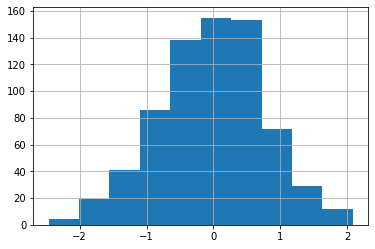

In [28]:
residuals.hist();

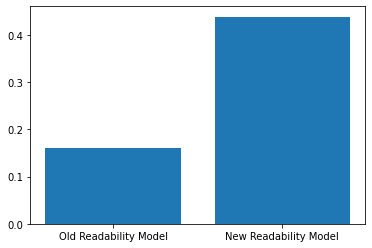

In [29]:
# visualizations of current readability to my model

r2_values = (0.16026900698741264, 0.4388851192530273)
plt.bar(x = ['Old Readability Model', 'New Readability Model'], height = r2_values);

# Nueral Networks

In [31]:
n_input = X_train_p.shape[1]

In [32]:
model = Sequential()
model.add(Dense(64, input_dim = n_input, activation = 'relu'))
# model.add(Dense(32, activation = 'relu'))


model.add(Dense(1, activation = None))

In [33]:
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse', 'acc'])

In [34]:
history = model.fit(X_train_p, y_train,
         epochs = 500,
         batch_size = 1024,
          validation_data = (X_test_p, y_test), 
          verbose = 0
         )

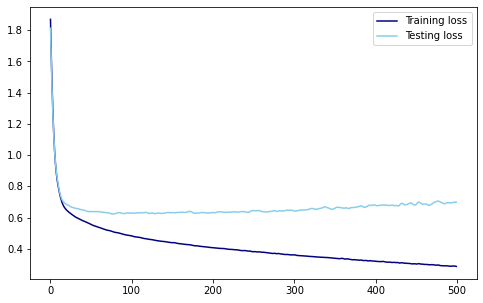

In [35]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [36]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
print('Training mse:',train_loss[-1])
print('Testing mse:',test_loss[-1])

Training mse: 0.286700040102005
Testing mse: 0.6982201337814331


**Interpretation**

With the model's testing loss diverging so much, early stopping would help; however, first l2 regularization will be implemented to see if we can reduce overfitting to make early stopping more effective.

In [37]:
l2_model = Sequential()
l2_model.add(Dense(64, input_dim = n_input,
                activation = 'relu',
               kernel_regularizer = l2(0.01)))

# l2_model.add(Dense(32, activation = 'relu',
#                kernel_regularizer = l2(0.01)))

l2_model.add(Dense(1, activation = None))

In [38]:
l2_model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse', 'acc'])

In [39]:
l2_history = l2_model.fit(X_train_p, y_train,
         epochs = 100,
         batch_size = 1024,
          validation_data = (X_test_p, y_test), 
          verbose = 0
         )

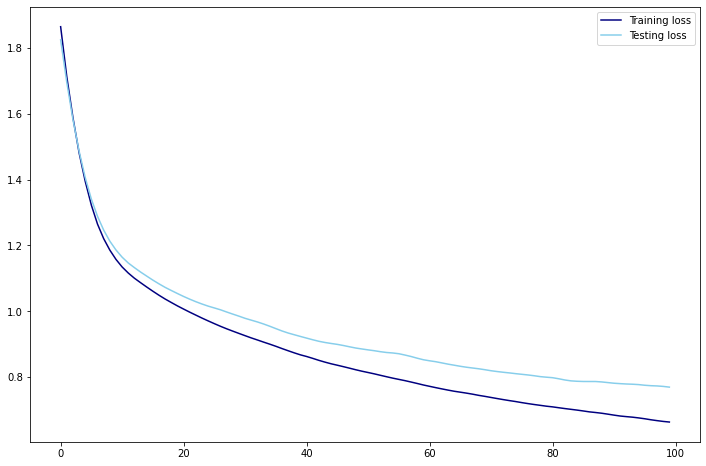

In [40]:
train_loss = l2_history.history['loss']
test_loss = l2_history.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [41]:
train_loss = l2_history.history['loss']
test_loss = l2_history.history['val_loss']
print('Training mse:',train_loss[-1])
print('Testing mse:',test_loss[-1])

Training mse: 0.6633569002151489
Testing mse: 0.7694642543792725


**Interpretation**

Regularization did well in handling the overfitting in the previous model version and opens the possibility to reintroduce more epochs and early stopping.

In [42]:
# #Dropout was set up to see the affect, however l2 was enough. 

# drop_l2_model = Sequential()
# drop_l2_model.add(Dense(64, input_dim = n_input,
#                 activation = 'relu',
#                kernel_regularizer = l2(0.01)))
# drop_l2_model.add(Dropout(0.2))


# drop_l2_model.add(Dense(32, activation = 'relu',
#                kernel_regularizer = l2(0.01)))
# drop_l2_model.add(Dropout(.2))


# drop_l2_model.add(Dense(1, activation = None))

# drop_l2_model.compile(loss = 'mean_squared_error',
#               optimizer = 'adam',
#               metrics = ['mse', 'acc'])

In [43]:
# drop_l2_history = drop_l2_model.fit(X_train, y_train,
#          epochs = 100,
#          batch_size = 1024,
#           validation_data = (X_test, y_test), 
#           verbose = 0
#          )

# train_loss = drop_l2_history.history['loss']
# test_loss = drop_l2_history.history['val_loss']
# plt.figure(figsize=(12, 8))
# plt.plot(train_loss, label='Training loss', color='navy')
# plt.plot(test_loss, label='Testing loss', color='skyblue')
# plt.legend();

In [44]:
# train_loss = drop_l2_history.history['loss']
# test_loss = drop_l2_history.history['val_loss']
# print('Training mse:',train_loss[-1])
# print('Testing mse:',test_loss[-1])

In [45]:
# Early Stopping With a higher regularization due to more epochs being reintroduced 

es_model = Sequential()
es_model.add(Dense(64, input_dim = n_input,
                activation = 'relu',
               kernel_regularizer = l2(0.1)))

# l2_model.add(Dense(32, activation = 'relu',
#                kernel_regularizer = l2(0.1)))

es_model.add(Dense(1, activation = None))

es_model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse', 'acc'])

early_stop = EarlyStopping(monitor = 'mse',
                          min_delta = 0,
                          patience = 10,
                          verbose = 0)

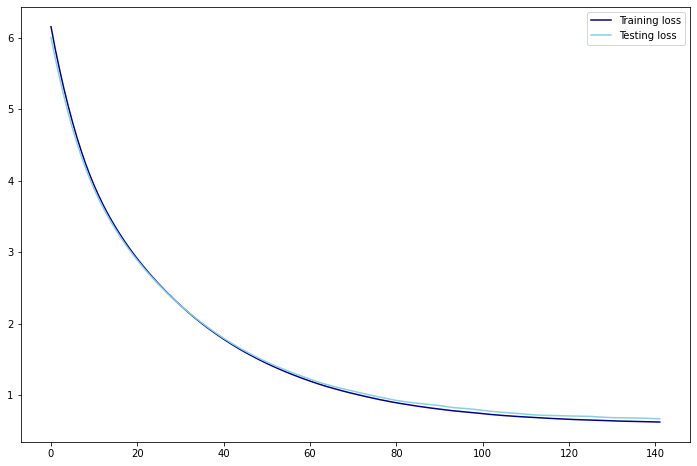

In [46]:
es_history = es_model.fit(X_train_p, y_train,
                                       epochs = 1000,
                                       batch_size = 1024,
                                       validation_data = (X_test_p, y_test), 
                                       verbose = 0,
                                       callbacks = [early_stop]
         )

train_loss = es_history.history['loss']
test_loss = es_history.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [47]:
train_loss = es_history.history['loss']
test_loss = es_history.history['val_loss']
print('Training mse:',train_loss[-1])
print('Testing mse:',test_loss[-1])

Training mse: 0.6247401237487793
Testing mse: 0.6715319156646729


**Interpretation**

Early stopping helps the performance of the model, however it still slightly underperforms compared to the sklearn models. A higher patience was tried but it led to a quick divergence of the train and test and a worse MSE. 

I could introduce a gridsearch to find the best regularization and hidden layers to optimize the model. However, since the regression models are outpeforming with minimal hyperparameter tuning, and do better with overfitting, as well as being computationally more efficient, the Ridge model will be the working model.

# Working Model: Ridge with PCA 

The production model to predict the final test set is Ridge, alpha 100 with PCA.

In [48]:
test = pd.read_csv('./data/test_cleaned.csv')

In [49]:
test.set_index(keys = 'id', inplace = True)
train.set_index(keys = 'id', inplace = True)

In [50]:
features = X_train.columns

In [51]:
features

Index(['avg_sent_length', 'subtree_per_sent', 'subtree_len',
       'subtree_len_by_num', 'node_types', 'total_dep', 'dep_dist',
       'pron_ratio', 'JJ', 'NNS', 'VBD', 'IN', 'NN', 'PRP', 'RB', 'VBN', 'RP',
       'CC', 'WDT', 'VBG', 'NNP', 'TO', 'VB', 'MD', 'PRP$', 'VBP', 'EX', 'VBZ',
       'PDT', 'JJR', 'NNPS', 'WP', 'RBR', 'unique_tags', 'unique_deps',
       'avg_word_freq', 'lexical_diversity', 'lexdiv_wordfreq', 'Outdoors',
       'Family', 'Science', 'Nature', 'War'],
      dtype='object')

In [52]:
def find_missing_test_columns(train, test, fill=True):
    '''
    Returns the list of missing columns from test that exist in train
    Paramters:
    train: the dataframe of training data
    test:the dataframe of test data
    fill=True: adds missing columns to test data and populates with 0 unless specified False
    '''
    
    missing = [col for col in train.columns if col not in test.columns]
    if fill==True:
        for col in missing:
            test[col] = 0
    if fill==False:
        return missing

In [53]:
find_missing_test_columns(train, test, fill=True)

In [54]:
X = train[features]
X_test = test[features]
y = train['target']

In [55]:
ss = StandardScaler()
X = ss.fit_transform(X)
X_test = ss.transform(X_test)

In [56]:
pca = PCA(n_components=28)
X = pca.fit_transform(X)
X_test = pca.transform(X_test)

In [57]:
pipe = Pipeline([
    ('model', Ridge(alpha = 100))])

pipe.fit(X, y)
preds = pipe.predict(X_test)

In [58]:
preds

array([-0.85611498, -0.41169338, -0.26716276, -1.82261474, -1.56381789,
       -0.51473553, -0.94646725])

In [59]:
pred_df = pd.DataFrame({'id':test.index, 'target':preds})

In [60]:
pred_df

,id,target
0,c0f722661,-0.856115
1,f0953f0a5,-0.411693
2,0df072751,-0.267163
3,04caf4e0c,-1.822615
4,0e63f8bea,-1.563818
5,12537fe78,-0.514736
6,965e592c0,-0.946467


In [61]:
pred_df.to_csv('./data/submission.csv', index = False)